# Rule-Based Classification for Calculating Potential Customer Return¶

# Business Problem
- A game company wants to create level-based new customer personas using certain characteristics of their customers and estimate how much revenue potential new customers from these segments could bring to the company.
- For example, the company wants to determine how much revenue a 25-year-old male user from Turkey, who uses iOS, can potentially generate on average.

# Data Set Story
- The "persona.csv" dataset contains the prices of products sold by an international game company and includes some demographic information about the users who purchased these products. The dataset consists of records generated from each sales transaction. This means that the table is not de-duplicated. In other words, a user with specific demographic characteristics may have made multiple purchases.

- **price**: The amount spent by the customer.
- **source**: The type of device the customer is connected to.
- **sex**: The gender of the customer.
- **country**: The country of the customer.
- **age**: The age of the customer.

In [1]:
# import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.simplefilter(action="ignore")

In [2]:
# Adjusting Row Column Settings
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

In [3]:
# Loading the Data Set
df = pd.read_csv("/kaggle/input/persona-dataset/persona.csv")

In [4]:
df.head()

,PRICE,SOURCE,SEX,COUNTRY,AGE
0,39,android,male,bra,17
1,39,android,male,bra,17
2,49,android,male,bra,17
3,29,android,male,tur,17
4,49,android,male,tur,17


In [5]:
# Preliminary examination of the data set
def check_df(dataframe, head=5):
    print('##################### Shape #####################')
    print(dataframe.shape)
    print('##################### Types #####################')
    print(dataframe.dtypes)
    print('##################### Head #####################')
    print(dataframe.head(head))
    print('##################### Tail #####################')
    print(dataframe.tail(head))
    print('##################### NA #####################')
    print(dataframe.isnull().sum())
    print('##################### Quantiles #####################')
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(5000, 5)
##################### Types #####################
PRICE       int64
SOURCE     object
SEX        object
COUNTRY    object
AGE         int64
dtype: object
##################### Head #####################
   PRICE   SOURCE   SEX COUNTRY  AGE
0     39  android  male     bra   17
1     39  android  male     bra   17
2     49  android  male     bra   17
3     29  android  male     tur   17
4     49  android  male     tur   17
##################### Tail #####################
      PRICE   SOURCE     SEX COUNTRY  AGE
4995     29  android  female     bra   31
4996     29  android  female     bra   31
4997     29  android  female     bra   31
4998     39  android  female     bra   31
4999     29  android  female     bra   31
##################### NA #####################
PRICE      0
SOURCE     0
SEX        0
COUNTRY    0
AGE        0
dtype: int64
##################### Quantiles #####################
        count  mean   std   min    

In [6]:
# Examination of numerical and categorical variables
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note Categorical variables include categorical variables with numeric appearance.
    Parameters
    ------
         dataframe: dataframe
                Dataframe to get variable names
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables
    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical view
    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))
    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != 'O']
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == 'O']
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f'Observations: {dataframe.shape[0]}')
    print(f'Variables: {dataframe.shape[1]}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

Observations: 5000
Variables: 5
cat_cols: 4
num_cols: 1
cat_but_car: 0
num_but_cat: 1


In [7]:
num_cols

['AGE']

         SOURCE  Ratio
android    2974  59.48
ios        2026  40.52
##########################################


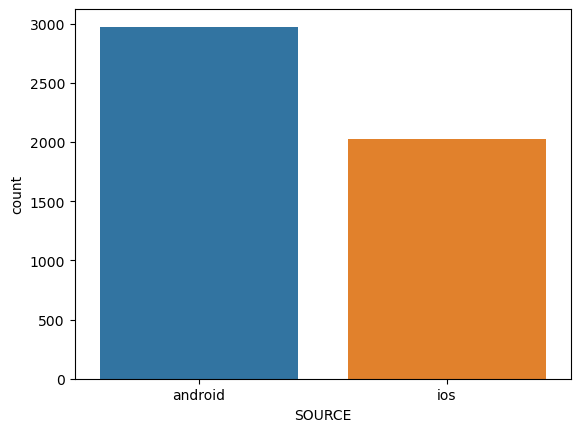

         SEX  Ratio
female  2621  52.42
male    2379  47.58
##########################################


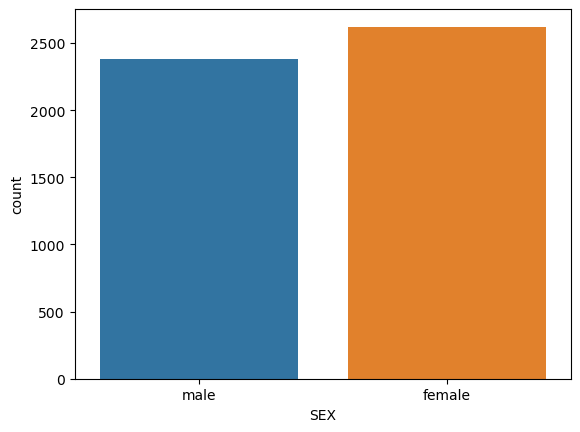

     COUNTRY  Ratio
usa     2065  41.30
bra     1496  29.92
deu      455   9.10
tur      451   9.02
fra      303   6.06
can      230   4.60
##########################################


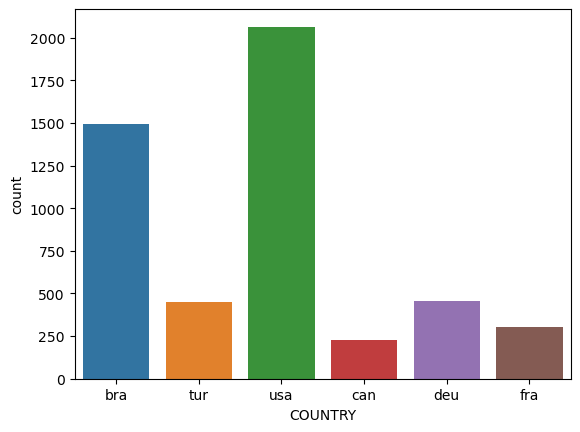

    PRICE  Ratio
29   1305  26.10
39   1260  25.20
49   1031  20.62
19    992  19.84
59    212   4.24
9     200   4.00
##########################################


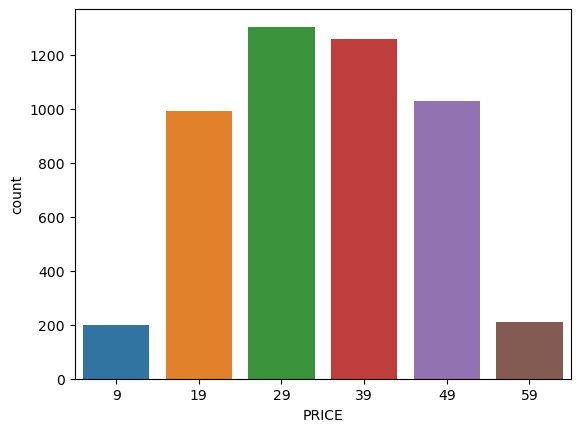

In [8]:
# Categorical variable analysis
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        'Ratio': 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print('##########################################')
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, plot=True)

count   5000.00
mean      23.58
std        9.00
min       15.00
5%        15.00
10%       15.00
20%       16.00
30%       17.00
40%       19.00
50%       21.00
60%       23.00
70%       26.00
80%       30.00
90%       36.00
95%       43.00
99%       53.00
max       66.00
Name: AGE, dtype: float64


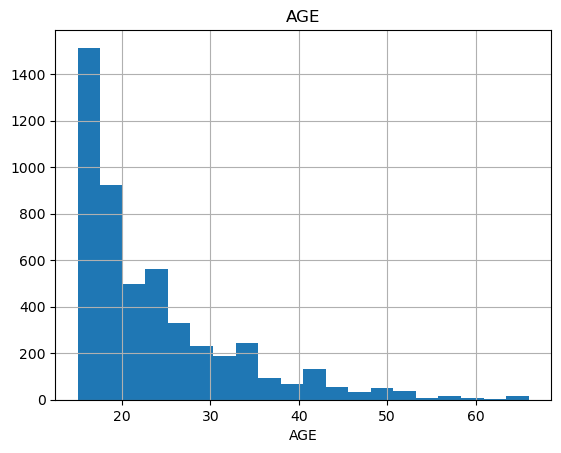

In [9]:
# Numerical variable analysis
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)

In [10]:
df["PRICE"].describe([0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]).T

count   5000.00
mean      34.13
std       12.46
min        9.00
5%        19.00
10%       19.00
20%       19.00
30%       29.00
40%       29.00
50%       39.00
60%       39.00
70%       39.00
80%       49.00
90%       49.00
95%       49.00
99%       59.00
max       59.00
Name: PRICE, dtype: float64

         TARGET_MEAN
SOURCE              
android        34.17
ios            34.07




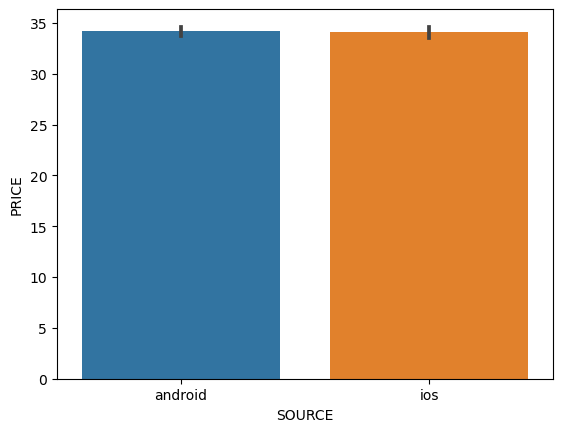

        TARGET_MEAN
SEX                
female        33.95
male          34.33




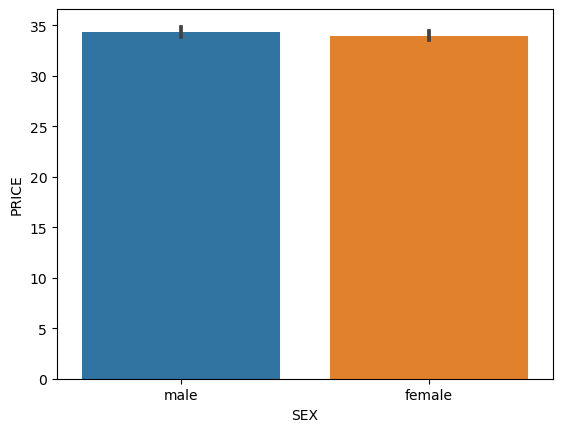

         TARGET_MEAN
COUNTRY             
bra            34.33
can            33.61
deu            34.03
fra            33.59
tur            34.79
usa            34.01




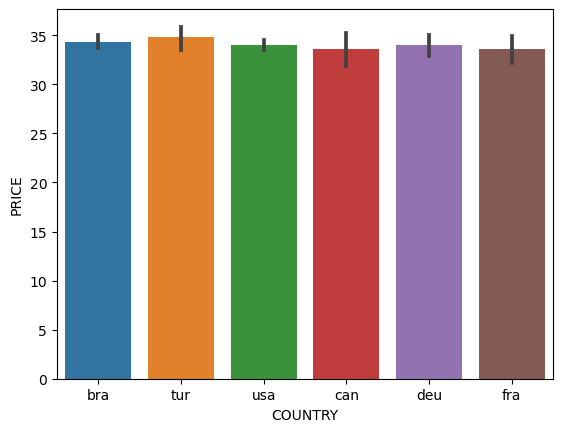

In [11]:
# Analysis of categorical variables by target variable
def target_summary_with_cat(dataframe, target, categorical_col, plot=False):
    print(pd.DataFrame({'TARGET_MEAN': dataframe.groupby(categorical_col)[target].mean()}), end='\n\n\n')
    if plot:
        sns.barplot(x=categorical_col, y=target, data=dataframe)
        plt.show(block=True)

for col in cat_cols:
    if col == 'PRICE':
        continue
    else:
        target_summary_with_cat(df, 'PRICE', col, plot=True)

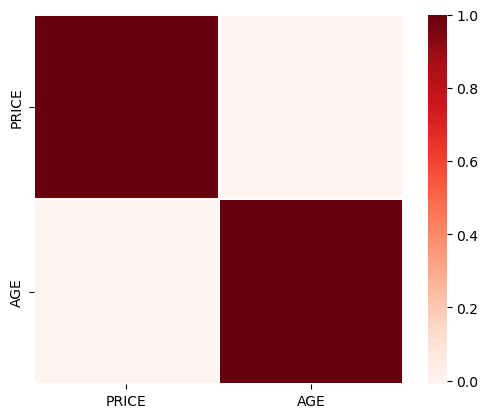

PRICE  AGE   0.01
dtype: float64

In [12]:
# Correlation Analysis of the Variables
def df_corr(dataframe, annot=True):
    sns.heatmap(dataframe.corr(), annot=annot, linewidths=.2, cmap='Reds', square=True)
    plt.show(block=True)

def high_correlated_cols(dataframe,head=10):
    corr_matrix = dataframe.corr().abs()
    corr_cols = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1)
                                   .astype(bool)).stack().sort_values(ascending=False)).head(head)
    return corr_cols

df_corr(df, annot=False)
high_correlated_cols(df, 15)

In [13]:
#What are the average earnings by COUNTRY, SOURCE, SEX, AGE?
agg_df = df.groupby(["COUNTRY", "SOURCE", "SEX", "AGE"]).agg({"PRICE": "mean"}).sort_values("PRICE", ascending=False)

In [14]:
agg_df.head()

,,,,PRICE
COUNTRY,SOURCE,SEX,AGE,
bra,android,male,46,59.00
usa,android,male,36,59.00
fra,android,female,24,59.00
usa,ios,male,32,54.00
deu,android,female,36,49.00


In [15]:
# Converting the names in the index to variable names.
agg_df = agg_df.reset_index()

In [16]:
agg_df["AGE"].describe()

count   348.00
mean     28.26
std      11.38
min      15.00
25%      19.00
50%      25.00
75%      34.00
max      66.00
Name: AGE, dtype: float64

In [17]:
# We determined the intervals in which the variable AGE will be split.
bins = [0, 18, 23, 30, 40, agg_df["AGE"].max()]

In [18]:
# We have defined what the names - labels - corresponding to the split points will be.
cut_labels = ["0_18", "19_23", "24_30", "31_40", "41_" + str(agg_df["AGE"].max())]

In [19]:
agg_df["cut_age"] = pd.cut(agg_df["AGE"], bins, labels=cut_labels)

In [20]:
agg_df.head()

,COUNTRY,SOURCE,SEX,AGE,PRICE,cut_age
0,bra,android,male,46,59.00,41_66
1,usa,android,male,36,59.00,31_40
2,fra,android,female,24,59.00,24_30
3,usa,ios,male,32,54.00,31_40
4,deu,android,female,36,49.00,31_40


In [21]:
agg_df["customer_level_based"] = [i[0].upper() + "_" + i[1].upper() + "_" + i[2].upper() + "_" + i[5].upper() for i in agg_df.values]   

In [22]:
agg_df.head()

,COUNTRY,SOURCE,SEX,AGE,PRICE,cut_age,customer_level_based
0,bra,android,male,46,59.00,41_66,BRA_ANDROID_MALE_41_66
1,usa,android,male,36,59.00,31_40,USA_ANDROID_MALE_31_40
2,fra,android,female,24,59.00,24_30,FRA_ANDROID_FEMALE_24_30
3,usa,ios,male,32,54.00,31_40,USA_IOS_MALE_31_40
4,deu,android,female,36,49.00,31_40,DEU_ANDROID_FEMALE_31_40


In [23]:
agg_df = agg_df[["customer_level_based", "PRICE"]]

In [24]:
agg_df.head()

,customer_level_based,PRICE
0,BRA_ANDROID_MALE_41_66,59.00
1,USA_ANDROID_MALE_31_40,59.00
2,FRA_ANDROID_FEMALE_24_30,59.00
3,USA_IOS_MALE_31_40,54.00
4,DEU_ANDROID_FEMALE_31_40,49.00


In [25]:
agg_df = agg_df.groupby("customer_level_based").agg({"PRICE": "mean"})

In [26]:
agg_df.head()

,PRICE
customer_level_based,
BRA_ANDROID_FEMALE_0_18,35.65
BRA_ANDROID_FEMALE_19_23,34.08
BRA_ANDROID_FEMALE_24_30,33.86
BRA_ANDROID_FEMALE_31_40,34.90
BRA_ANDROID_FEMALE_41_66,36.74


In [27]:
agg_df = agg_df.reset_index()

In [28]:
agg_df.head()

,customer_level_based,PRICE
0,BRA_ANDROID_FEMALE_0_18,35.65
1,BRA_ANDROID_FEMALE_19_23,34.08
2,BRA_ANDROID_FEMALE_24_30,33.86
3,BRA_ANDROID_FEMALE_31_40,34.90
4,BRA_ANDROID_FEMALE_41_66,36.74


In [29]:
agg_df["SEGMENT"] = pd.qcut(agg_df["PRICE"], 4, labels=["D", "C", "B", "A"])

In [30]:
agg_df.groupby("SEGMENT").agg({"PRICE": "mean"})

,PRICE
SEGMENT,
D,29.21
C,33.51
B,35.00
A,38.69


In [31]:
new_persona_1 = "TUR_ANDROID_FEMALE_31_40"

In [32]:
agg_df[agg_df["customer_level_based"] == new_persona_1]

,customer_level_based,PRICE,SEGMENT
72,TUR_ANDROID_FEMALE_31_40,41.83,A


In [33]:
new_persona_2 = "FRA_IOS_FEMALE_31_40"

In [34]:
agg_df[agg_df["customer_level_based"] == new_persona_2]

,customer_level_based,PRICE,SEGMENT
63,FRA_IOS_FEMALE_31_40,32.82,C
